# ASR-SA
## Lucida AI Evaluation

### Goal
Investigate the relationship between the errors of ASR (Automatic Speech Recognition) and the errors of SA (Sentiment Analysis).

### Experiment Setup
![alt text](exp_setup.png "exp_setup")

### Explanation

1. I chose three variants of ASR: `fisher`, `librispeech`, and `tedlium`, each corresponding to a DNN model trained on a particular dataset

2. I tested two implementations of SA: [`LSTM`](https://github.com/stanfordnlp/treelstm) and [`Google SA`](https://cloud.google.com/natural-language/).

### Generate Quries from Original Data

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string
from operator import itemgetter
from random import shuffle
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

In [2]:
# Remove pucntuations from the string.
def stripped_str(str):
    return str.translate(str.maketrans('', '', string.punctuation))

# To generate the queries from the original data file,
# shuffle the original data and print 400
# (200 positive and 200 negative) unique sentences.
# (There are a lot of duplicates in the original data).
# Save the output to file `text/query.txt`.
# Original data format:
# <score>\t<sentence>
# where score is 0 (negative) or 1 (positive).
# The original data is downloaded from 
# https://inclass.kaggle.com/c/si650winter11/data.
def get_queries_from_original_data(original_data_path):
    # Print random (up to) 200 "unique" strings from the raw data lines.
    def get_random_200(lines):    
        seen = []
        i = 0
        for ans, sentence in lines:
            if i >= 200:
                break
            has_seen = False
            for s in seen:
                if stripped_str(sentence).lower() in s:
                    has_seen = True
                    break
            if has_seen:
                continue
            seen.append(stripped_str(sentence).lower())
            print('"' + sentence + '",' + str(ans))
            i += 1
            
    # Open the file and put the lines into two buckets.
    file = open(original_data_path, 'r')
    lines = file.readlines()
    pos = []
    neg = []
    for line in lines:
        ans = int(line.split('\t')[0])
        sentence = line.split('\t')[1].rstrip('\n').replace('"','')
        if ans == 1: # postive
            pos.append((ans, sentence))
        elif ans == 0: # negative
            neg.append((ans, sentence))
        else:
            raise RuntimeError
    # Randomly shuffle the buckets.
    shuffle(pos)
    shuffle(neg)
    print('query,answer')
    get_random_200(pos)
    get_random_200(neg)
    
# get_queries_from_original_data('text/original_training_data.txt')

### Generate Raw Data
See `README.md` for details.

### Generate `DataFrame` from ASR Results

In [3]:
# Return a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_sa/speech/0_Helloworld.wav,"hello world."
# Its first line must have be the header!
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    lines.pop(0) # pop the header
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = pd.read_csv('text/query.txt')

asr_labels = ['fisher', 'librispeech', 'tedlium']

for asr_label in asr_labels:
    data = data.join \
    (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
                            'transcript_{}'.format(asr_label)))

### Generate `DataFrame` from LSTM Results

In [4]:
# Return a dictionary from LSTM result data.
# Format of the LSTM result data file:
# query,0,"This quiz sucks and Harry Potter sucks ok bye.."
# result,0,"4"
# where the first field is either "query" or "result",
# the second field is the query ID, 
# and the third field is the query or result based on the first field.
# There can be duplicate queries due to how Treadmill sends them.
# The dictionary maps the query string to the quantized result.
def get_dict_from_lstm_result(lstm_result_path):
    file = open(lstm_result_path, 'r')
    lines = file.readlines()
    file.close()
    query_result = {}
    id_query = {}
    for line in lines:
        line = line.rstrip('\n')
        label = line.split(',')[0]
        query_id = line.split(',')[1]
        third = line.split(',')[2:]
        third = ','.join(x for x in third)
        third = third.replace('"', '')
        if label == 'query':
            query = third
            id_query[query_id] = query
            if not query in query_result:
                query_result[query] = None
        elif label == 'result':
            result = float(third)
            query = id_query[query_id]
            if query_result[query] is None:
                # In LSTM, 0 and 1 mean negative, 
                # 3 means neutral,
                # 4 and 5 mean positive.
                # Potential problem:
                # If the result is 3, quantize into 0.5,
                # which would never be correct.
                result = 1 if (int(result) > 3) else \
                0.5 if (result == 3) else 0
                query_result[query] = result
#     for k, v in query_result.items():
#         print(k, v)
    return query_result

# Return a DataFrame from LSTM result data.
# In order to match the query in the LSTM result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_lstm_result(lstm_result_path, header, data, match_col):
    query_result = get_dict_from_lstm_result(lstm_result_path)
    results = []
    for j, match_transcript in enumerate(data[match_col]):
        if match_transcript != '':
            if not match_transcript in query_result:
                raise RuntimeError('Cannot find the query ' + match_transcript)
            result = query_result[match_transcript]
        else:
            result = -1 # ASR did not return any result, so SA must be wrong!
        results.append((j, result))
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in results], columns=[header])
    return df
    
sa_labels = [('fisher_lstm', 'transcript_fisher'), \
             ('librispeech_lstm', 'transcript_librispeech'), \
             ('tedlium_lstm', 'transcript_tedlium'), \
             ('regular_lstm', 'query')]

for sa_label, match_col in sa_labels:
    data = data.join \
    (get_df_from_lstm_result('sa_result_{}.txt'.format(sa_label), \
                           'answer_{}'.format(sa_label), data, \
                           match_col), lsuffix='')
    

### Generate `DataFrame` from Google SA Results

In [5]:
# Return a DataFrame from LSTM result data.
# In order to match the query in the LSTM result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_google_result(google_result_path, header, data, match_col):
    google_data = pd.read_csv(google_result_path)
    results = []
    for j, asr_output in enumerate(data[match_col]):
        match_row = -1
        if asr_output != '':
            for i, sa_input in enumerate(google_data['query']):
                if sa_input == asr_output:
                    match_row = i
                    break
            if match_row == -1:
                raise RuntimeError('Cannot find the query ' + asr_output)
            result = google_data['polarity'].ix[match_row]
            # Google returns -1 for negative and 1 for positive.
            result = 0 if (result == -1) else 1 if (result == 1) else 'null'
        else:
            result = -1 # ASR did not return any result, so SA must be wrong!
        results.append((j, result))
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in results], columns=[header])
    return df
    
sa_labels = [('fisher_google', 'transcript_fisher'), \
             ('librispeech_google', 'transcript_librispeech'), \
             ('tedlium_google', 'transcript_tedlium'), \
             ('regular_google', 'query')]

for sa_label, match_col in sa_labels:
    data = data.join \
    (get_df_from_google_result('sa_result_{}.txt'.format(sa_label), \
                           'answer_{}'.format(sa_label), data, \
                           match_col), lsuffix='')
    

### Display Data as a Table

In [6]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = data[['query', 'answer', 'answer_regular_lstm','answer_regular_google',  \
             'transcript_fisher', 'answer_fisher_lstm', 'answer_fisher_google', \
             'transcript_librispeech', 'answer_librispeech_lstm', 'answer_librispeech_google', \
             'transcript_tedlium', 'answer_tedlium_lstm', 'answer_tedlium_google']]
data.to_csv('data.txt') # save to disk

In [19]:
data[0:2]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
0,Mission Impossible 3 was excellent.,1,1.0,0,mission impossible three was excellent.,1.0,1,MISSION IMPOSSIBLE THREE WAS EXCELLENT.,1,0,mission impossible three was excellent.,1.0,1
1,Love the Harry Potter series though I try not to talk about it too much..,1,0.0,1,well the harry potter series so i try not to talk about it too much.,1.0,0,LOVE THE HARRY POTTER SERIES THOUGH I TRY NOT TO TALK ABOUT IT TOO MUCH.,1,0,i love the harry potter series though i try not to talk about it too much.,1.0,1


### Interesting Observation of Google SA

Visit [Google Cloud Natural Language API (Beta)](https://cloud.google.com/natural-language/),
scroll down to the "Try the API",
first enter `MISSION IMPOSSIBLE THREE WAS excellent`
then enter `MISSION IMPOSSIBLE THREE WAS EXCELLENT`

![alt text](google_demo_0.png "google_demo_0")

![alt text](google_demo_1.png "google_demo_1")

![alt text](google_demo_2.png "google_demo_2")

### Collect Statistics and Plot

In [20]:
# Return the error rate of str2 given str1 as the correct text.
# Potential problem: penalize extra words generated by the ASR.
def error_rate(str1, str2):
    if str2 == '':
        return 1.0 # ASR returns empty string
    split1 = stripped_str(str1).lower().split()
    split2 = stripped_str(str2).lower().split()
    correct_count = 0
    wront_count = 0
    for word in split1:
        if word in split2:
            split2.remove(word)
            correct_count += 1
    for word in split2:
        wront_count += 1
    return wront_count / (correct_count + wront_count)

# print(error_rate('Hello World!', "extra hello, world , extra..."))

# Return true if the answer is the same as the correct answer.
# Return false otherwise.
def answer_is_correct(answer, correct_answer):
    return answer == correct_answer

# Analyze the data for the specified ASR and return the statistics.
def analyze(data, asr_name, sa_name, verbose=True):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    scores = np.zeros(size)
    relative_scores = np.zeros(size)
    regular_sa_result = np.zeros(size)
    sa_result = np.zeros(size)
    for j, answer in enumerate(data['_'.join(['answer', asr_name, sa_name])]):
        correct_answer = data['answer'][j]
        regular_answer = data['_'.join(['answer', 'regular', sa_name])][j]
        if answer_is_correct(regular_answer, correct_answer):
            # Regualr is correct.
            regular_sa_result[j] = 1
            if not answer_is_correct(answer, correct_answer):
                # Become wrong.
                scores[j] = 0
                relative_scores[j] = -2
            else:
                # Still correct.
                scores[j] = 1
                relative_scores[j] = 1
                sa_result[j] = 1
        else:
            # Regular is wrong.
            if not answer_is_correct(answer, correct_answer):
                # Still wrong.
                scores[j] = 0
                relative_scores[j] = -1
            else:
                # Become correct!
                scores[j] = 1
                relative_scores[j] = 2
                sa_result[j] = 1
                
    if verbose:
        wrong_indices = []
        for i, result in enumerate(sa_result):
            if result == 0:
                wrong_indices.append(i)
        print(wrong_indices)
    avg_sa_accuracy = np.count_nonzero(sa_result) / sa_result.size
    avg_regular_sa_accuracy = np.count_nonzero(regular_sa_result) / regular_sa_result.size
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_sa_accuracy:', avg_sa_accuracy, \
          'avg_regular_sa_accuracy', avg_regular_sa_accuracy)
    return {'asr_name': asr_name, 'sa_name': sa_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'regular_sa_result': regular_sa_result, 'sa_result': sa_result, \
            'avg_sa_accuracy': avg_sa_accuracy, \
            'avg_regular_sa_accuracy': avg_regular_sa_accuracy}

# Set up plotting scheme.
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

# Plot the relative scores vs error rates for a particular ASR+SA combination.
def plot_score_vs_error(color, asr_name, sa_name, asr_errors, relative_scores, **extras):
    plt.xlabel('ASR Error Rate')
    plt.ylabel('SA Relative Score')
    plt.title(' '.join([asr_name, sa_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)

### Plot LSTM Performance

1. Baseline is LSTM with the original text query
2. Score is relative to the baseline:
    - If the baseline is correct but the ASR causes it to be wrong, the score is -2
    - If the baseline is correct and the ASR does not change the result, the score is +1
    - If the baseline is wrong and the ASR does not change the result, the score is -1
    - If the baseline is wrong but the ASR causes it to be correct, the score is +2


[3, 4, 8, 10, 17, 22, 25, 32, 33, 37, 41, 42, 49, 56, 58, 66, 68, 70, 75, 76, 79, 81, 84, 85, 88, 91, 105, 112, 121, 123, 127, 130, 136, 145, 146, 155, 157, 159, 163, 167, 168, 182, 183, 191, 201, 202, 203, 204, 205, 206, 208, 210, 211, 218, 221, 223, 224, 226, 227, 228, 231, 232, 234, 237, 239, 241, 243, 250, 252, 256, 258, 260, 262, 263, 264, 265, 266, 267, 268, 269, 273, 279, 280, 281, 282, 283, 286, 288, 290, 292, 293, 295, 296, 297, 299, 300, 302, 304, 306, 307, 309, 310, 311, 315, 316, 317, 319, 320, 321, 323, 324, 326, 327, 328, 330, 331, 334, 335, 337, 338, 341, 344, 347, 351, 354, 356, 357, 360, 361, 362, 364, 365, 371, 372, 374, 378, 380, 382, 384, 385, 386, 389, 390, 393, 395, 396, 398, 399]
avg_asr_error: 0.384553843759 avg_sa_accuracy: 0.63 avg_regular_sa_accuracy 0.6475


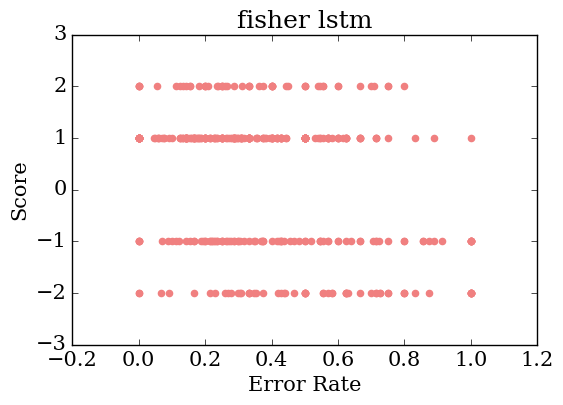

In [9]:
lstm_stats_list = []
lstm_stats_list.append(analyze(data, 'fisher', 'lstm'))
plot_score_vs_error('lightcoral', **lstm_stats_list[-1])

[167, 183, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,

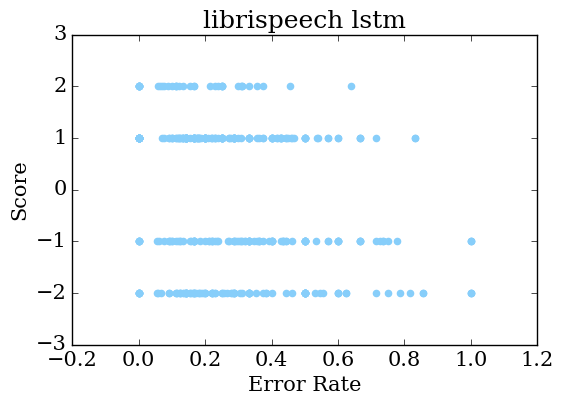

In [10]:
lstm_stats_list.append(analyze(data, 'librispeech', 'lstm'))
plot_score_vs_error('lightskyblue', **lstm_stats_list[-1])

[4, 8, 15, 16, 17, 20, 25, 32, 37, 41, 42, 48, 52, 55, 58, 66, 75, 76, 79, 84, 87, 88, 98, 105, 107, 112, 125, 127, 133, 135, 136, 140, 143, 152, 155, 157, 159, 164, 167, 173, 174, 183, 185, 191, 195, 201, 202, 203, 204, 205, 206, 208, 210, 211, 214, 216, 218, 220, 221, 223, 224, 226, 227, 228, 231, 232, 234, 237, 239, 240, 241, 243, 245, 249, 250, 252, 260, 262, 263, 264, 265, 266, 267, 269, 270, 273, 279, 280, 281, 283, 286, 288, 290, 291, 292, 293, 295, 296, 297, 299, 301, 303, 305, 306, 307, 310, 311, 312, 313, 315, 316, 317, 318, 320, 321, 323, 324, 329, 330, 334, 335, 338, 341, 343, 344, 347, 350, 351, 352, 354, 356, 358, 360, 361, 362, 364, 365, 371, 374, 375, 376, 379, 380, 381, 382, 383, 386, 389, 392, 393, 394, 395, 396, 399]
avg_asr_error: 0.301639022983 avg_sa_accuracy: 0.615 avg_regular_sa_accuracy 0.6475


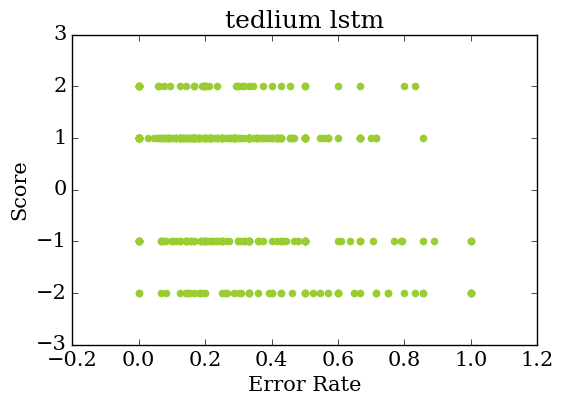

In [11]:
lstm_stats_list.append(analyze(data, 'tedlium', 'lstm'))
plot_score_vs_error('yellowgreen', **lstm_stats_list[-1])

In [12]:
# Return the data from the list of sa statistics (one for each ASR model).
def gather_data_for_sa_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_sa_accuracy_list = [stats['avg_sa_accuracy'] for stats in stats_list]
    avg_regular_sa_accuracy_list = \
    [stats['avg_regular_sa_accuracy'] for stats in stats_list]
    avg_sa_accuracy_drop_list = \
    [stats['avg_sa_accuracy'] - avg_regular_sa_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_sa_accuracy_drop_percentage_list = \
    [ (avg_sa_accuracy_drop / avg_regular_sa_accuracy_list[i]) * 100 \
     for i, avg_sa_accuracy_drop in enumerate(avg_sa_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, \
avg_regular_sa_accuracy_list, avg_sa_accuracy_drop_list, avg_sa_accuracy_drop_percentage_list

# Plot the performance of a particular sa under the influence of different ASR models.
def plot_sa_vs_asr(stats_list, sa_name):    
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average SA Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(sa_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, avg_regular_sa_accuracy_list, \
    avg_sa_accuracy_drop_list, avg_sa_accuracy_drop_percentage_list = \
    gather_data_for_sa_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_sa_accuracy_list, color='orange')
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{} ({:.2f},{})\n$\Delta$Accuracy={:.2f}({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_sa_accuracy_list[i], \
         avg_sa_accuracy_drop_list[i], \
         avg_sa_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_sa_accuracy_list[i]), \
                    fontsize=10)

# Plot the performance of a different sas under the influence of different ASR models.
def plot_sas_vs_asr(list_of_stats_list, list_of_sa_name, list_of_colors):
    assert(len(list_of_stats_list) == len(list_of_sa_name))
    assert(len(list_of_sa_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average SA Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'.format(', '.join(list_of_sa_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        sa_name = list_of_sa_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, avg_regular_sa_accuracy_list, \
        avg_sa_accuracy_drop_list, avg_sa_accuracy_drop_percentage_list = \
        gather_data_for_sa_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_sa_accuracy_list, label=sa_name, color=list_of_colors[i])
        plt.legend(loc=3)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{} ($\Delta$Accuracy {:.2f}%)'.format \
            (asr_name_list[i], avg_sa_accuracy_drop_percentage_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_sa_accuracy_list[i]), \
                         fontsize=10)

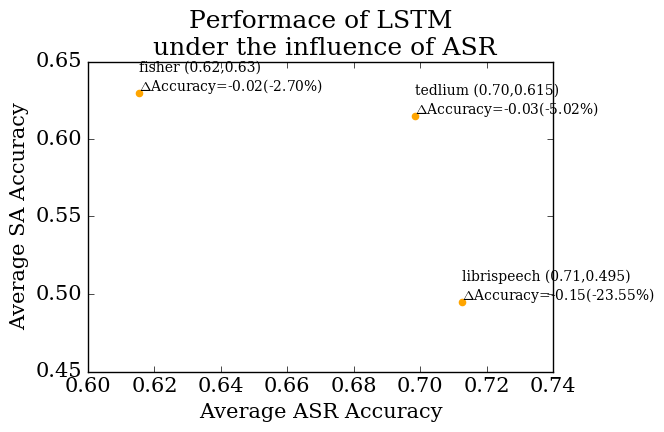

In [13]:
plot_sa_vs_asr(lstm_stats_list, 'LSTM')

### Plot Google SA Performance

[1, 4, 10, 17, 25, 29, 48, 55, 58, 66, 68, 75, 76, 79, 85, 87, 96, 98, 105, 108, 112, 120, 136, 144, 149, 155, 157, 164, 167, 168, 182, 183, 184, 191, 201, 202, 205, 208, 210, 212, 217, 218, 223, 225, 226, 230, 234, 237, 239, 241, 249, 252, 256, 262, 265, 267, 279, 280, 286, 288, 290, 293, 295, 297, 302, 305, 306, 311, 316, 319, 320, 321, 327, 334, 335, 338, 340, 341, 350, 351, 354, 357, 362, 364, 365, 371, 373, 374, 381, 384, 386, 391, 392, 395, 396]
avg_asr_error: 0.384553843759 avg_sa_accuracy: 0.7625 avg_regular_sa_accuracy 0.8075


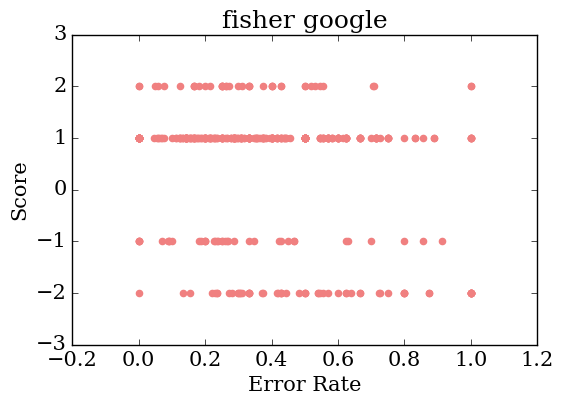

In [14]:
googlesa_stats_list = []
googlesa_stats_list.append(analyze(data, 'fisher', 'google'))
plot_score_vs_error('lightcoral', **googlesa_stats_list[-1])

[0, 1, 4, 10, 11, 17, 20, 25, 33, 37, 40, 41, 42, 46, 49, 52, 56, 57, 58, 66, 67, 68, 75, 76, 79, 84, 85, 96, 98, 105, 108, 112, 119, 127, 128, 129, 136, 139, 146, 149, 154, 155, 159, 167, 174, 175, 178, 181, 182, 183, 189, 191, 194, 195, 200, 201, 203, 204, 208, 209, 210, 217, 221, 226, 230, 232, 240, 241, 258, 262, 265, 267, 271, 273, 275, 281, 282, 286, 288, 291, 292, 293, 294, 295, 297, 299, 300, 302, 309, 311, 314, 317, 321, 324, 327, 329, 330, 331, 334, 335, 338, 341, 347, 349, 351, 356, 357, 360, 364, 366, 370, 380, 382, 383, 385, 387, 392, 393, 395]
avg_asr_error: 0.287522207123 avg_sa_accuracy: 0.7025 avg_regular_sa_accuracy 0.8075


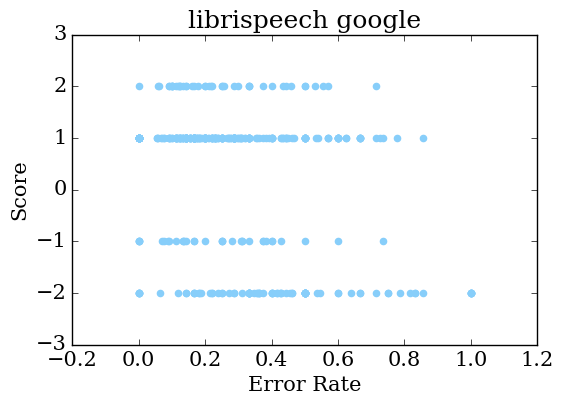

In [15]:
googlesa_stats_list.append(analyze(data, 'librispeech', 'google'))
plot_score_vs_error('lightskyblue', **googlesa_stats_list[-1])

[4, 16, 17, 25, 29, 32, 37, 39, 48, 49, 52, 53, 55, 66, 76, 84, 85, 87, 105, 107, 108, 112, 127, 136, 144, 149, 155, 167, 174, 183, 184, 185, 201, 202, 203, 204, 208, 210, 211, 212, 217, 218, 221, 223, 226, 228, 237, 239, 240, 241, 252, 255, 262, 264, 265, 267, 269, 273, 281, 282, 283, 286, 288, 290, 292, 293, 295, 297, 299, 301, 303, 304, 305, 306, 307, 314, 317, 318, 320, 321, 324, 326, 328, 329, 330, 334, 335, 338, 341, 343, 344, 347, 351, 354, 357, 358, 360, 362, 364, 371, 373, 374, 377, 378, 380, 381, 382, 383, 389, 391, 393, 395, 398, 399]
avg_asr_error: 0.301639022983 avg_sa_accuracy: 0.715 avg_regular_sa_accuracy 0.8075


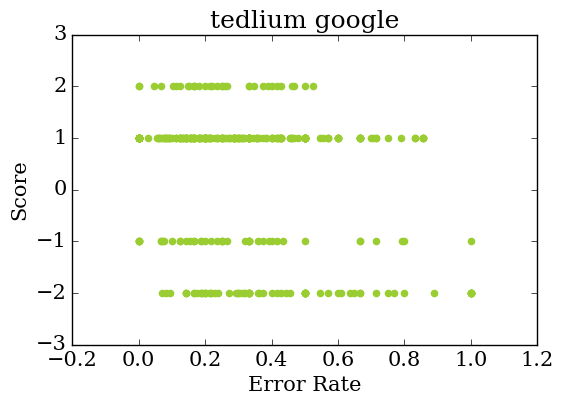

In [16]:
googlesa_stats_list.append(analyze(data, 'tedlium', 'google'))
plot_score_vs_error('yellowgreen', **googlesa_stats_list[-1])

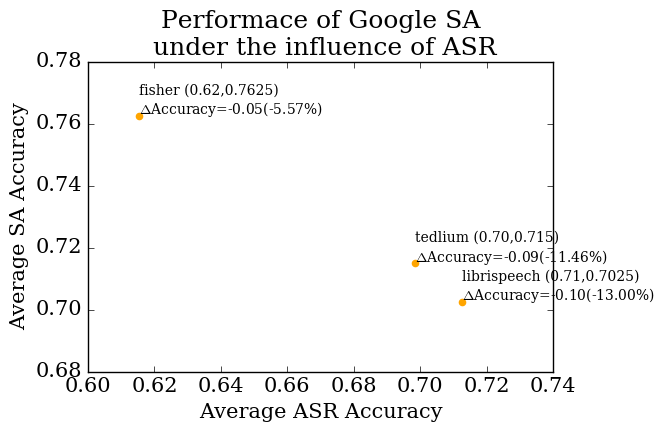

In [17]:
plot_sa_vs_asr(googlesa_stats_list, 'Google SA')

### Summary

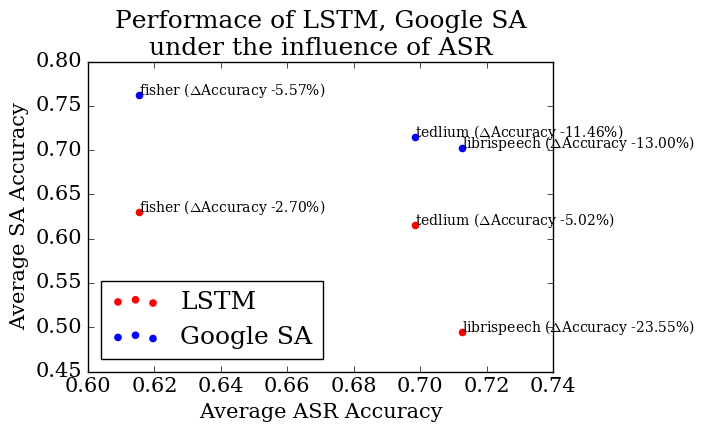

In [18]:
plot_sas_vs_asr([lstm_stats_list, googlesa_stats_list], \
                ['LSTM', 'Google SA'], ['red', 'blue'])

### Resources

1. SQuAD: The Stanford Question Answering Dataset: https://rajpurkar.github.io/SQuAD-explorer/